In [ ]:
%%capture
!pip install transformers datasets accelerate -U

In [ ]:
import json
from pathlib import Path
import numpy as np

import torch
from tqdm.notebook import tqdm
from datasets import load_dataset
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForQuestionAnswering

from torch.utils.data import DataLoader
from transformers import AdamW

In [ ]:
tqdm.pandas()

### DPR - dense pair retrieval

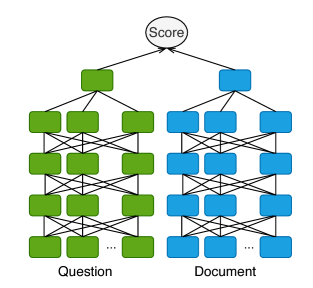

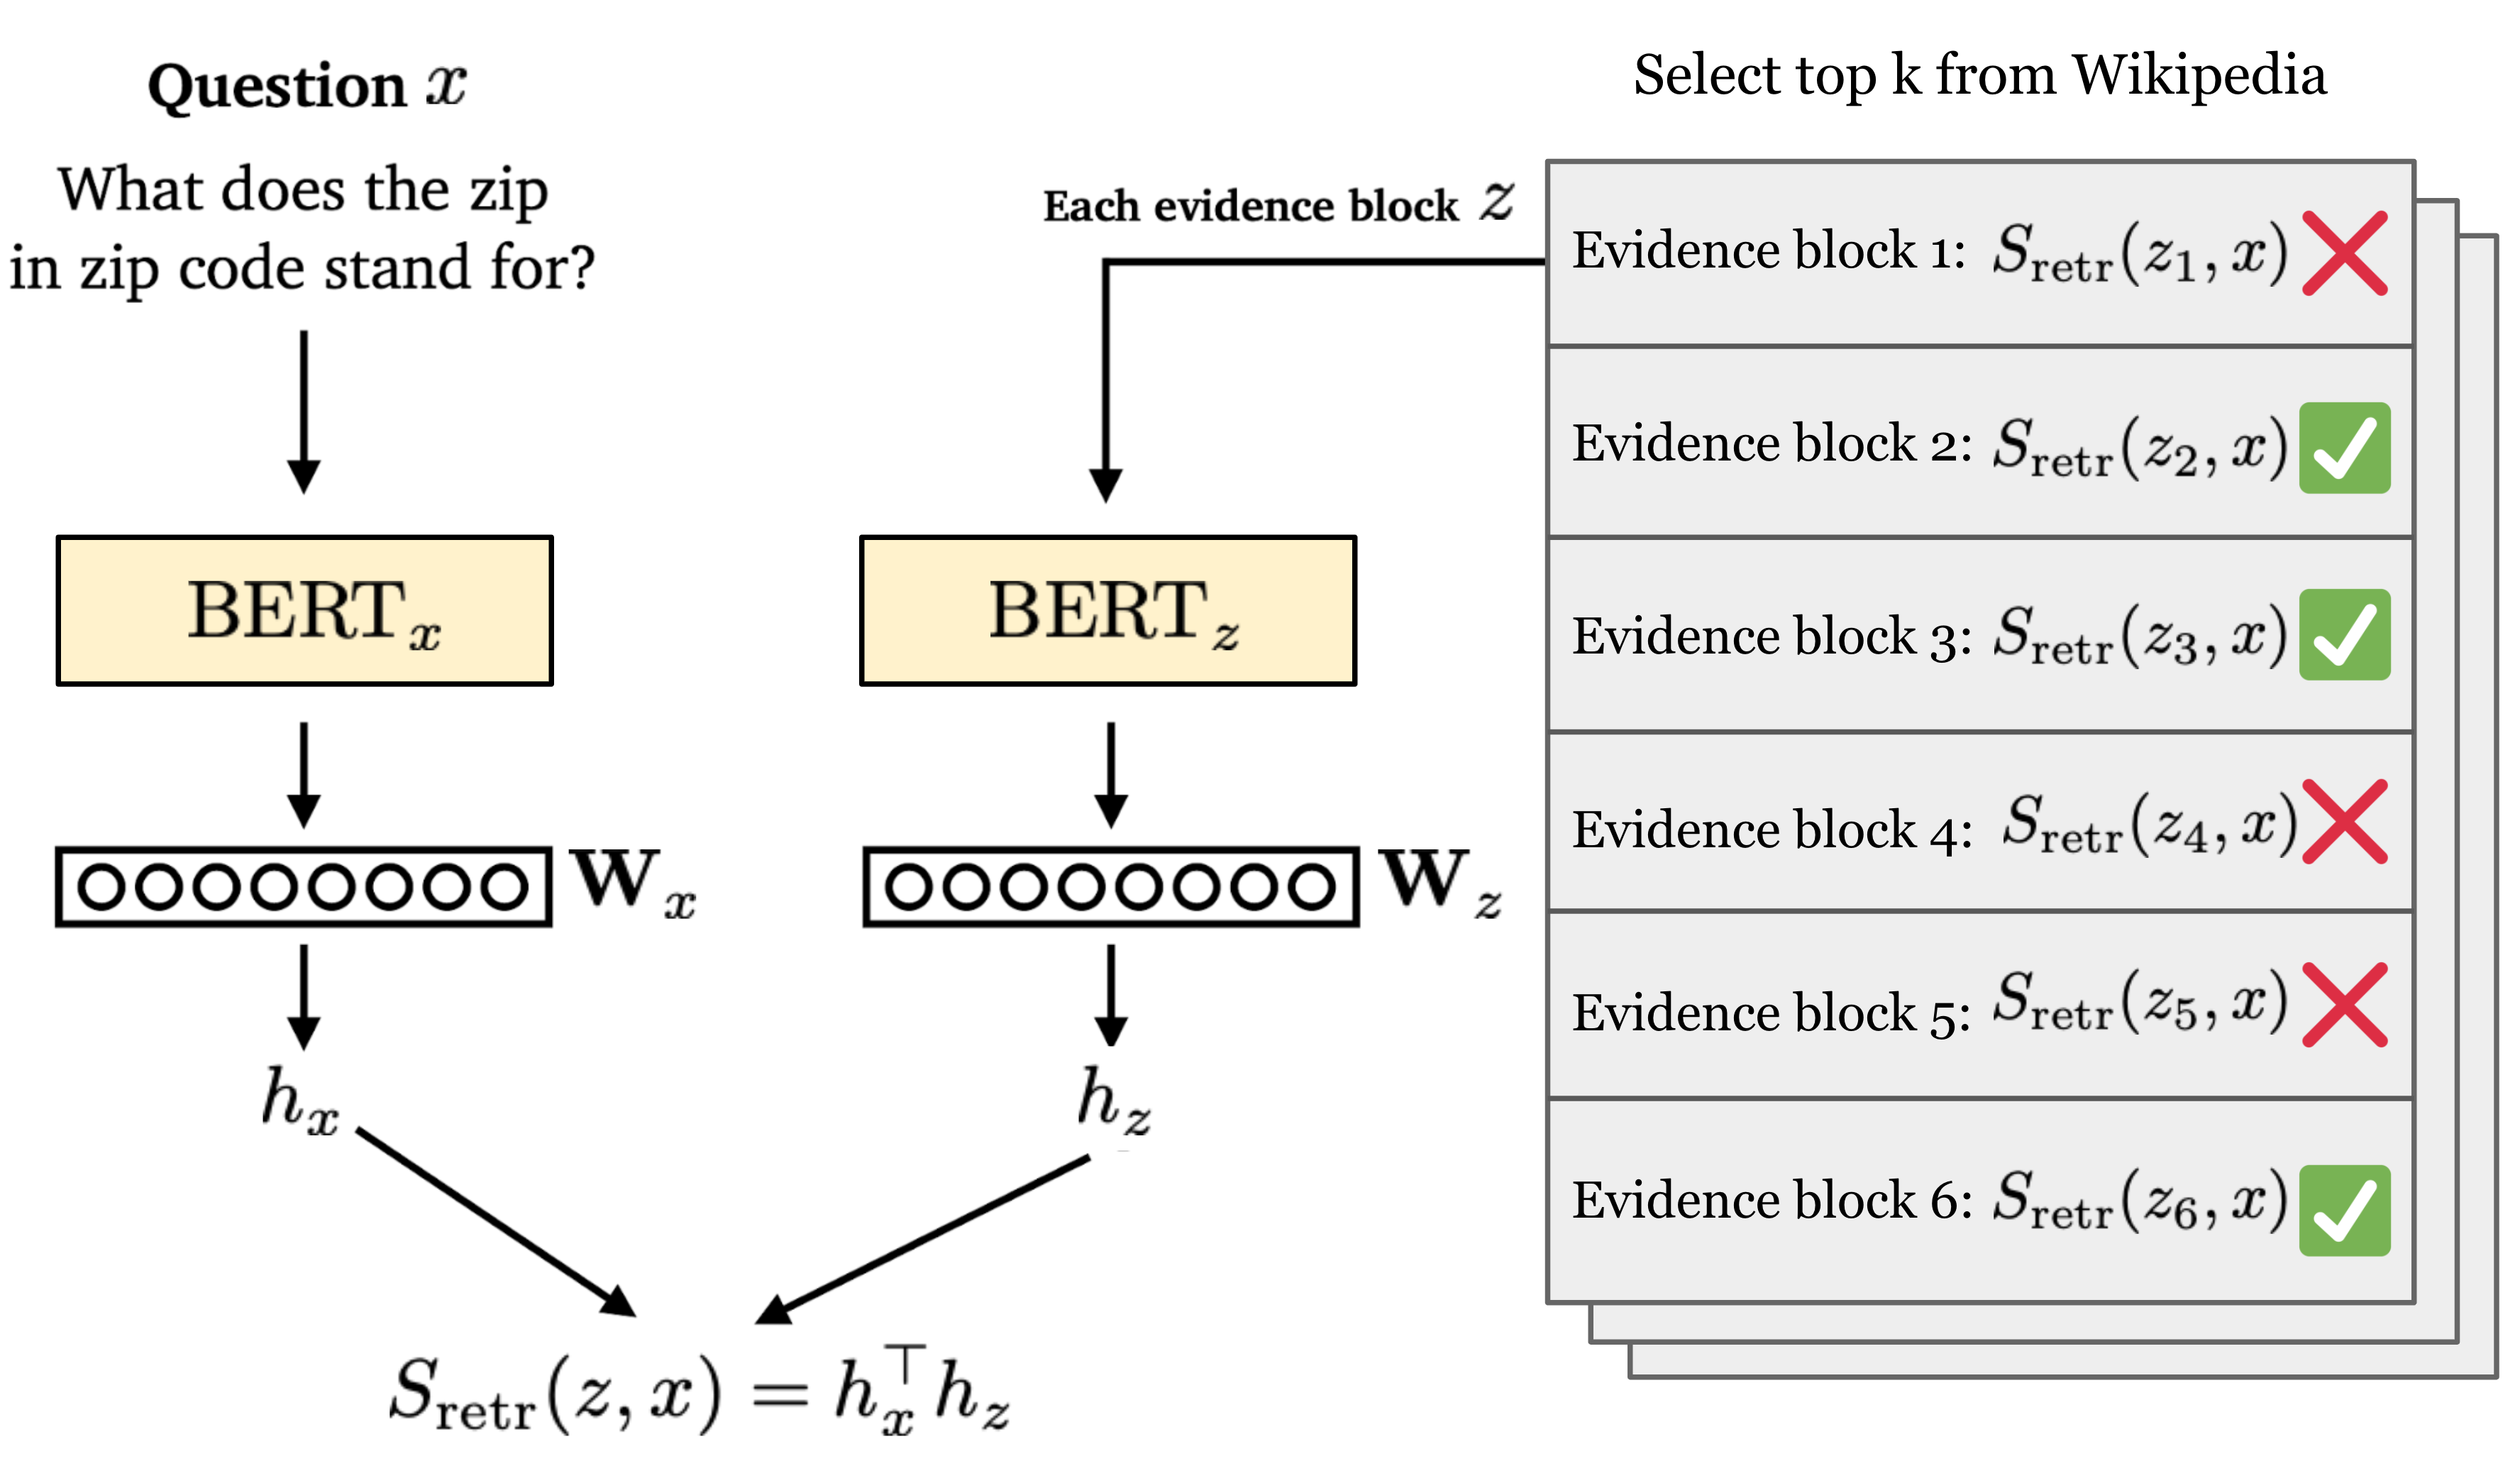

Два независимых кодировщика на основе BERT для получения представлений абзацев и вопросов, а затем вычисляет меру близости между полученными векторами.

**Inforamation retrieval architecture**

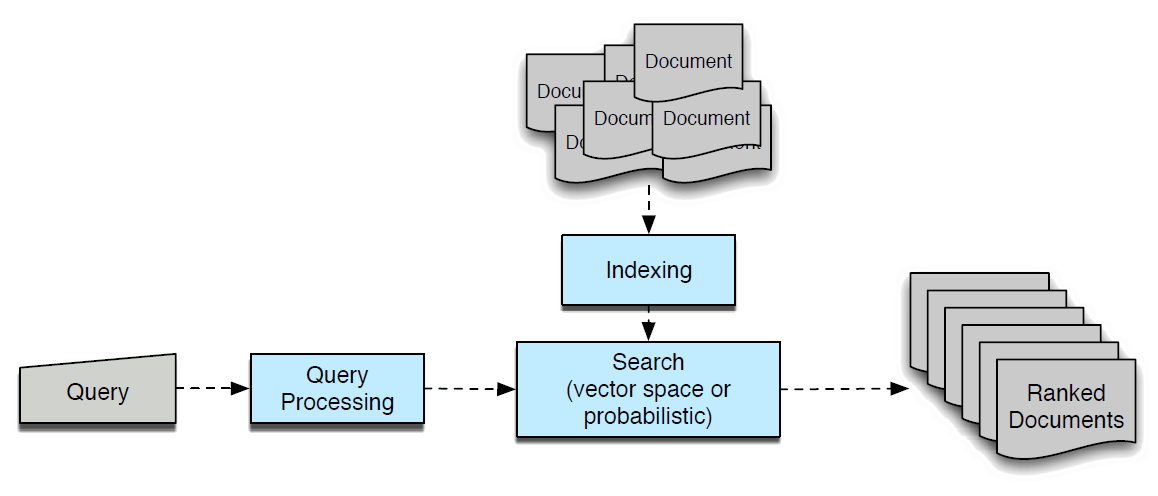

In [ ]:
from transformers import DPRReader, DPRReaderTokenizer

dpr-reader-single-nq-base предобучена на корпусе [NQ (Natural Questions)](https://huggingface.co/datasets/nq_open) - The dataset was designed for end-to-end question answering. The questions were mined from real Google search queries and the answers were spans in Wikipedia articles identified by annotators.

In [ ]:
tokenizer = DPRReaderTokenizer.from_pretrained('facebook/dpr-reader-single-nq-base')
model = DPRReader.from_pretrained('facebook/dpr-reader-single-nq-base')
encoded_inputs = tokenizer(
  questions=["What is love ?"],
  titles=["Haddaway"],
  texts=["'What Is Love' is a song recorded by the artist Haddaway"],
  return_tensors='pt'
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRReaderTokenizer'.
Some weights of the model checkpoint at facebook/dpr-reader-single-nq-base were not used when initializing DPRReader: ['span_predictor.encoder.bert_model.pooler.dense.bias', '

In [ ]:
outputs = model(**encoded_inputs)

start_logits = outputs.start_logits
end_logits = outputs.end_logits
relevance_logits = outputs.relevance_logits
print(relevance_logits)

tensor([-1.2456], grad_fn=<ViewBackward0>)


In [ ]:
answer_start = torch.argmax(start_logits)  # Get the most likely beginning of answer with the argmax of the score
answer_end = torch.argmax(end_logits) + 1  # Get the most likely end of answer with the argmax of the score

In [ ]:
answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(encoded_inputs['input_ids'][0][answer_start:answer_end]))

print(f"Answer: {answer}\n")

Answer: a song



In [ ]:
text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""

questions = [
    "How many pretrained models are available in Transformers?",
    "What does Transformers provide?",
    "Transformers provides interoperability between which frameworks?",
]

title = "Transformers"

encoded_inputs = tokenizer(
  questions=questions,
  titles=[title] * 3,
  texts=[text] * 3,
  return_tensors='pt',
  truncation=True,
  padding=True
)
outputs = model(**encoded_inputs)
answer_start_scores = outputs["start_logits"]
answer_end_scores = outputs["end_logits"]

answer_starts = torch.argmax(answer_start_scores, dim=1)  # Get the most likely beginning of answer with the argmax of the score
answer_ends = torch.argmax(answer_end_scores, dim=1) + 1  # Get the most likely end of answer with the argmax of the score

answers = [tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(encoded_inputs['input_ids'][0][answer_start:answer_end])) \
          for answer_start, answer_end in zip(answer_starts, answer_ends)]

for question, answer in zip(questions, answers):
    print(f"Question: {question}")
    print(f"Answer: {answer}\n")

Question: How many pretrained models are available in Transformers?
Answer: over 32 +

Question: What does Transformers provide?
Answer: ##trained - bert )

Question: Transformers provides interoperability between which frameworks?
Answer: provides general - purpose architecture



### Answer Span Extraction

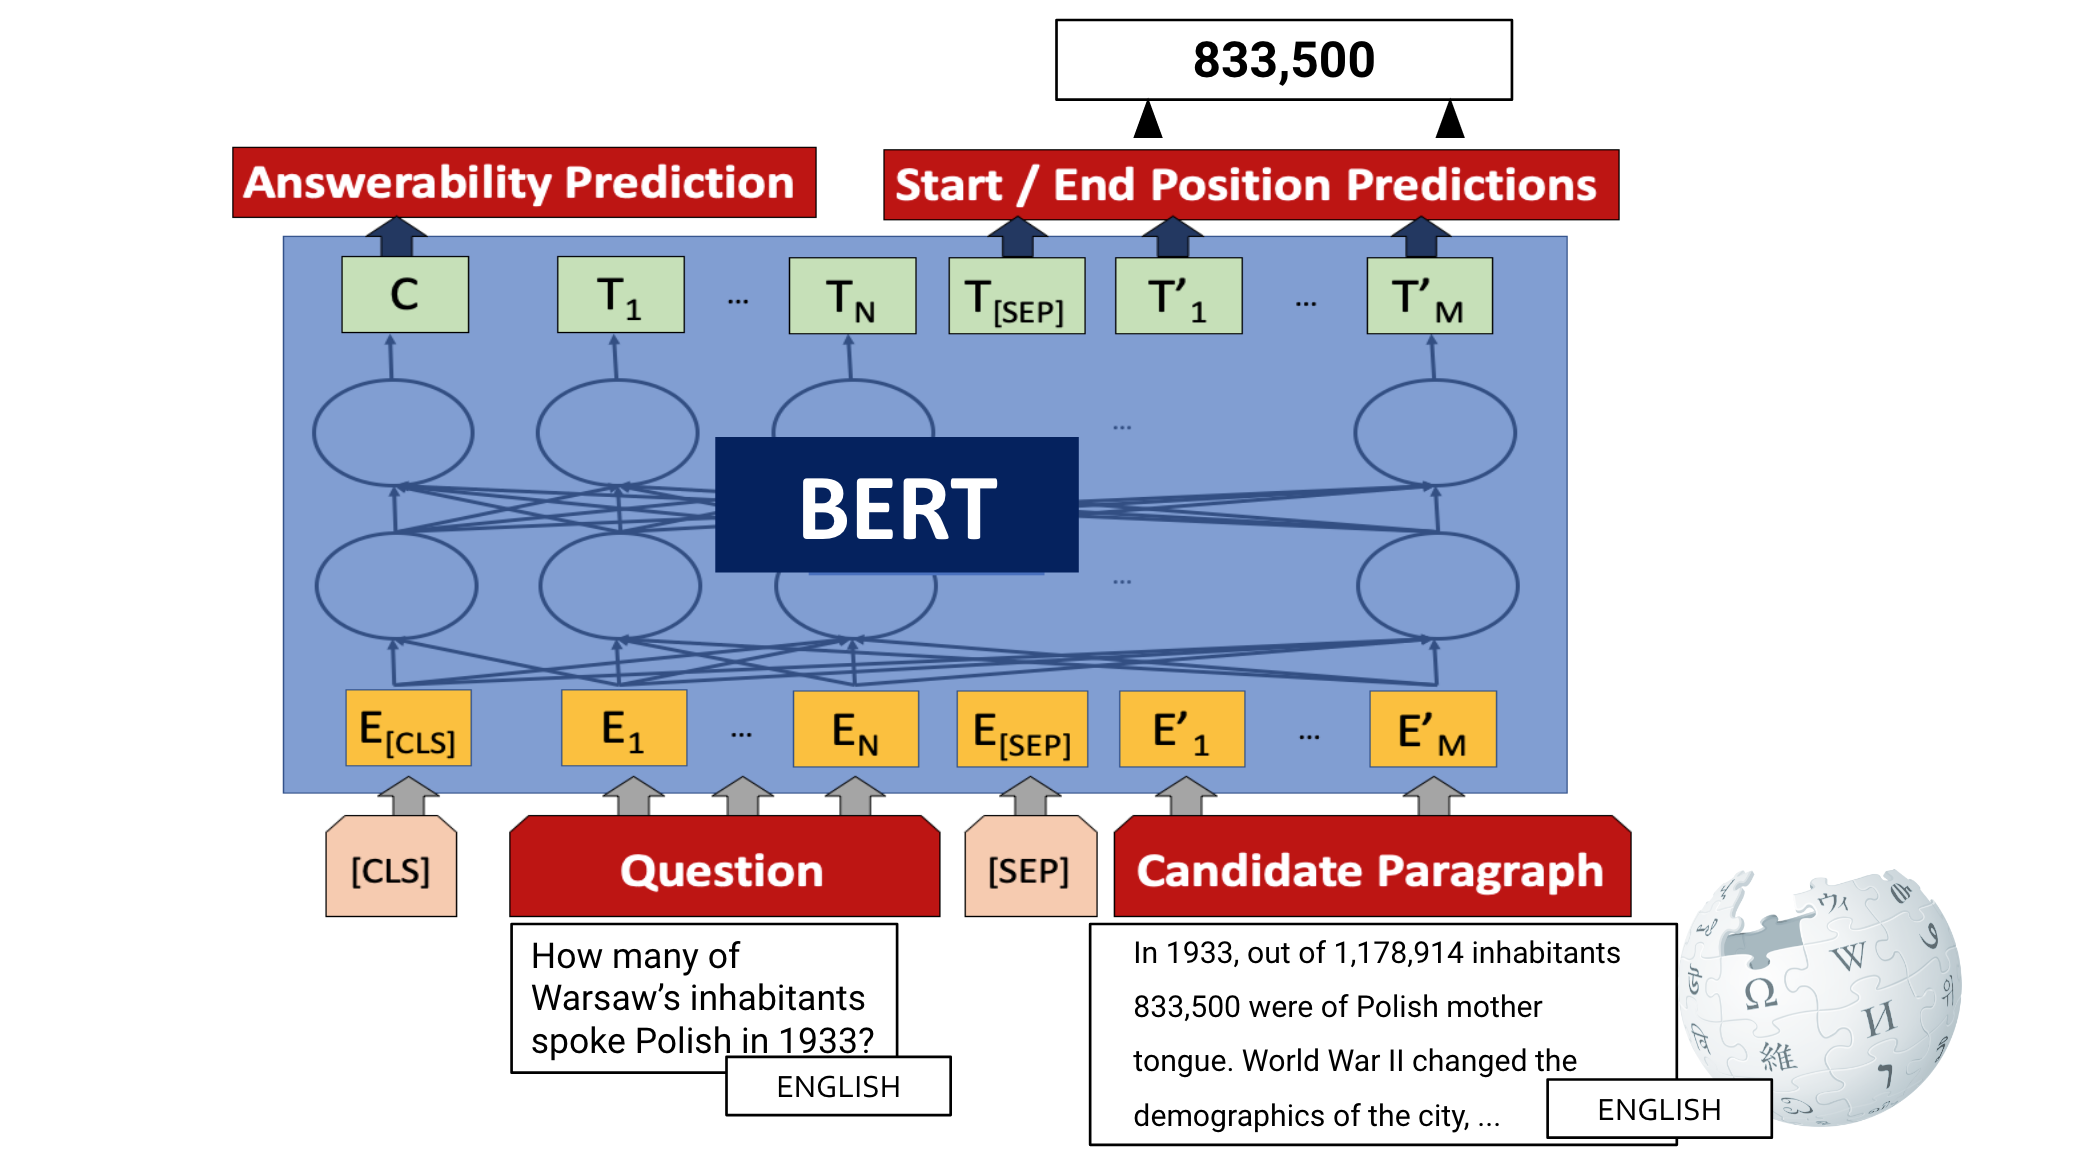

Transformers & SQuAD 2.0

In [ ]:
from datasets import load_dataset

squad = load_dataset("rajpurkar/squad")

In [ ]:
squad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [ ]:
squad['train'][0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

In [ ]:
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

In [ ]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [ ]:
tokenized_squad = squad.map(preprocess_function, batched=True, remove_columns=squad["train"].column_names)

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [ ]:
small_train_dataset = tokenized_squad["train"].shuffle(seed=42).select(range(10000))
small_eval_dataset = tokenized_squad["validation"].shuffle(seed=42).select(range(2000))

In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [ ]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained("distilbert/distilbert-base-uncased")

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tokenized_squad

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 10570
    })
})

In [ ]:
training_args = TrainingArguments(
    output_dir="squad_qa_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,2.565700,1.683280
2,1.554600,1.547989
3,1.244200,1.547697


TrainOutput(global_step=1875, training_loss=1.6537593587239583, metrics={'train_runtime': 1151.643, 'train_samples_per_second': 26.05, 'train_steps_per_second': 1.628, 'total_flos': 2939694750720000.0, 'train_loss': 1.6537593587239583, 'epoch': 3.0})

In [ ]:
question = "How many programming languages does BLOOM support?"
context = "BLOOM has 176 billion parameters and can generate text in 46 languages natural languages and 13 programming languages."

Инференс через pipeline

In [ ]:
from transformers import pipeline

question_answerer = pipeline("question-answering", model="squad_qa_model/checkpoint-1500")
question_answerer(question=question, context=context)

{'score': 0.22845807671546936,
 'start': 10,
 'end': 95,
 'answer': '176 billion parameters and can generate text in 46 languages natural languages and 13'}

или

In [ ]:
import torch
from transformers import AutoModelForQuestionAnswering, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("squad_qa_model/checkpoint-1500")
inputs = tokenizer(question, context, return_tensors="pt")

model = AutoModelForQuestionAnswering.from_pretrained("squad_qa_model/checkpoint-1500")

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)

answer_start_index = outputs.start_logits.argmax()
answer_end_index = outputs.end_logits.argmax()

In [ ]:
predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
tokenizer.decode(predict_answer_tokens)

'176 billion parameters and can generate text in 46 languages natural languages and 13'

### Deeppavlov & SberQUAD

[Sberquad dataset](https://huggingface.co/datasets/sberquad)

In [ ]:
!pip install deeppavlov

In [ ]:
!python -m deeppavlov install squad_ru_bert

In [ ]:
from deeppavlov import build_model, configs

model_qa = build_model(configs.squad.squad_ru_bert, download=True)
model_qa(
    ["""В протерозойских отложениях органические остатки встречаются намного чаще, чем в архейских. Они представлены известковыми выделениями сине-зелёных водорослей, ходами червей,
    остатками кишечнополостных. Кроме известковых водорослей, к числу древнейших растительных остатков относятся скопления графито-углистого вещества, образовавшегося в результате разложения
    Corycium enigmaticum. В кремнистых сланцах железорудной формации Канады найдены нитевидные водоросли, грибные нити и формы, близкие современным кокколитофоридам. В железистых кварцитах
    Северной Америки и Сибири обнаружены железистые продукты жизнедеятельности бактерий."""],
    ["чем представлены органические остатки?"]
)

2023-10-31 10:52:13.136 INFO in 'deeppavlov.core.data.utils'['utils'] at line 95: Downloading from http://files.deeppavlov.ai/v1/squad/squad_ru_torch_bert.tar.gz to /root/.deeppavlov/squad_ru_torch_bert.tar.gz
INFO:deeppavlov.core.data.utils:Downloading from http://files.deeppavlov.ai/v1/squad/squad_ru_torch_bert.tar.gz to /root/.deeppavlov/squad_ru_torch_bert.tar.gz
100%|██████████| 1.74G/1.74G [02:00<00:00, 14.4MB/s]
2023-10-31 10:54:15.67 INFO in 'deeppavlov.core.data.utils'['utils'] at line 276: Extracting /root/.deeppavlov/squad_ru_torch_bert.tar.gz archive into /root/.deeppavlov/models
INFO:deeppavlov.core.data.utils:Extracting /root/.deeppavlov/squad_ru_torch_bert.tar.gz archive into /root/.deeppavlov/models


(…)cased/resolve/main/tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

(…)bert-base-cased/resolve/main/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

(…)rubert-base-cased/resolve/main/vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

(…)sed/resolve/main/special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForQuestionAnswering: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from 

[['известковыми выделениями сине-зелёных водорослей, ходами червей,\n    остатками кишечнополостных'],
 [109],
 [1.0]]

### Что еще почитать?

[Retrieving and Reading : A Comprehensive
Survey on Open-domain Question Answering](https://arxiv.org/pdf/2101.00774.pdf)

[HuggingFace Question Answering](https://huggingface.co/tasks/question-answering)

